<a href="https://colab.research.google.com/github/FieldTien/MvtecAD-supervise-learning-Grad-Cam/blob/main/VGG16_2class%2BGrad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Download the dataset 
Dataset is alredy resized into 256x256

The second file is train,valid and test data directory  

In [ ]:
!gdown --id 1IC_J1TEwDIhs44rMwm8GkRzzwkH5OlxU
!gdown --id 1XQ3JODnyzti76oKrYIsrfQyrzWPgMB_f
! unzip mvtecad_supervise.zip

In [2]:
import os
import os.path
import pickle
import numpy as np
from pathlib import Path
from PIL import Image
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
import time
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,roc_auc_score
from sklearn.preprocessing import label_binarize

In two class, transform the label to binary class(normal and abnormal) 

data_path label 0-14 is normal and 15-29 is abnormal
*wood,tile,leather,transistor,hazelnut,toothbrush,capsule,pill,screw,carpet,bottle,grid,cable, zipper, metal_nut*
*   Training set : 2990
*   Validation  set  : 796
*   Testing  set  : 1568

In [3]:
Path = "/content/VGG16_2class.pkl"
data_path = "/content/train_val_test_split.txt"
with open(data_path, "rb") as fp:   
   data_dir = pickle.load(fp) 
train_images,train_labels= data_dir[0][0], data_dir[0][1] 
for i in range(len(train_labels)):
  if(train_labels[i]>=15): train_labels[i]=int(1)
  else: train_labels[i]=int(0)
valid_images,valid_labels= data_dir[1][0], data_dir[1][1] 
for i in range(len(valid_labels)):
  if(valid_labels[i]>=15): valid_labels[i]=int(1)
  else: valid_labels[i]=int(0)
test_images,test_labels= data_dir[2][0], data_dir[2][1]  
for i in range(len(test_labels)):
  if(test_labels[i]>=15): test_labels[i]=int(1)
  else: test_labels[i]=int(0)
print(train_images[:5],train_labels[:5])
print(valid_images[:5],valid_labels[:5])
print(test_images[:5],test_labels[:5]) 
print("Train data size:",len(train_images))
print("Valid data size:",len(valid_images))
print("Test data size:",len(test_images))

['mvtecad_supervise/wood/train/good/022.png', 'mvtecad_supervise/wood/train/good/043.png', 'mvtecad_supervise/wood/train/good/038.png', 'mvtecad_supervise/wood/test/good/018.png', 'mvtecad_supervise/wood/train/good/163.png'] [0, 0, 0, 0, 0]
['mvtecad_supervise/wood/train/good/013.png', 'mvtecad_supervise/wood/train/good/193.png', 'mvtecad_supervise/wood/train/good/178.png', 'mvtecad_supervise/wood/train/good/088.png', 'mvtecad_supervise/wood/train/good/223.png'] [0, 0, 0, 0, 0]
['mvtecad_supervise/wood/train/good/221.png', 'mvtecad_supervise/wood/train/good/168.png', 'mvtecad_supervise/wood/train/good/056.png', 'mvtecad_supervise/wood/train/good/173.png', 'mvtecad_supervise/wood/train/good/063.png'] [0, 0, 0, 0, 0]
Train data size: 2990
Valid data size: 796
Test data size: 1568


In [4]:
def default_loader(path):
    return Image.open(path).convert('RGB')
class myImageFloder(data.Dataset):
    def __init__(self, images, labels, training, loader=default_loader):
        self.images = images
        self.labels = labels
        self.loader = loader
        self.training = training
    def __getitem__(self, index):
        images = self.images[index]
        labels_id = self.labels[index]
        images = self.loader(images)
        labels = labels_id    
        if(self.training==True):
          t_list = [     
            transforms.Resize(size=224),
            transforms.RandomRotation(degrees=300),
            transforms.RandomHorizontalFlip(),
            #transforms.CenterCrop(size=224),  # Image net standards
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                      [0.229, 0.224, 0.225]) ] 
        else :
            t_list = [transforms.Resize(size=224),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485, 0.456, 0.406], 
                            [0.229, 0.224, 0.225])]         
        processed = transforms.Compose(t_list)
        images = processed(images)
        return images, labels
    def __len__(self):
        return len(self.images)

The normal(0) and abnormal(1) weight in training is 0.9739:3.026 and we use this weights into loss function

In [5]:
class_count=np.array([train_labels.count(0),train_labels.count(1)])
class_sum = np.sum(class_count)
revese_count = np.flipud(class_count)
weight=revese_count/class_sum
loss_weight = weight/weight[0]
loss_weight = weight*4
print("The weight of each class : ",loss_weight)

The weight of each class :  [0.97391304 3.02608696]


###Define the anomaly detection model
Here we use the imageNet pretrained VGG16 model and unfreeze all the residual block

In [6]:
import torchvision.models as models
model=models.vgg16(pretrained=True)
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()     
        # get the pretrained VGG19 network
        # disect the network to access its last convolutional layer
        self.features_conv = model.features[:10]    
        self.Conv2d_0 = model.features[10:]
        self.avgpool = model.avgpool
        self.classifier = nn.Sequential(*[model.classifier[i] for i in range(3)],nn.Linear(4096,512),nn.ReLU(True),nn.Dropout(0.2),nn.Linear(512,2)) 
        for param in self.features_conv.parameters():
          param.requires_grad = False
        for param in self.Conv2d_0.parameters():   
          param.requires_grad = True     
        for param in self.classifier.parameters():   
          param.requires_grad = True 
    def forward(self, x):
        x = self.features_conv(x)  
        x = self.Conv2d_0(x)  
        x = self.avgpool(x)  
        x = x.view((-1, 25088))
        x = self.classifier(x)
        return x  
model = VGG16()              
for param in model.parameters():
    param.requires_grad = True

device = torch.device('cuda')    
model.to(device) 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG16(
  (features_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv2d_0): Sequential(
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_si

###Define the evaluation, train, validation function

In [7]:
def sklearn_evaluate(y_true, y_pred, evalaute = True):
  y_pred_logit = y_pred
  _, y_pred = torch.max(y_pred.data, 1)
  predict = y_pred.to('cpu').detach().numpy()
  truth_all = y_true.to('cpu').numpy().astype(int)  
  f1 = f1_score(truth_all, predict, average='binary')*100
  acc = accuracy_score(truth_all, predict)*100
  if evalaute:
    confusion = confusion_matrix(truth_all, predict)
    Softmax= torch.nn.Softmax(dim=1)
    y_score = Softmax(y_pred_logit).to('cpu').detach().numpy()[:,1]
    auc_score = roc_auc_score(truth_all, y_score)*100
    return (acc, f1, confusion, auc_score)
  else:
    return (acc, f1) 

def train(model, optimizer,loss_weight,trainloader):
  model.train()
  epoch_loss ,epoch_acc,epoch_f_score = 0 , 0 , 0
  for batch, labels in trainloader:
      batch = batch.to(device)
      labels = labels.to(device)
      weights=torch.tensor(loss_weight).float()
      criterion = nn.CrossEntropyLoss(weight=weights).to(device)
      optimizer.zero_grad()
      predict = model(batch)
      loss = criterion(predict, labels)
      loss.backward()
      optimizer.step()
      acc, f1 = sklearn_evaluate(labels, predict, evalaute = False)
      epoch_loss  += loss.item()
      epoch_acc += acc
      epoch_f_score += f1       
  return (epoch_loss/len(trainloader) ,epoch_acc/len(trainloader) ,epoch_f_score/len(trainloader) )   

def validate(model, loader):
    model.eval()
    epoch_loss = 0
    criterion = nn.CrossEntropyLoss().to(device)
    predict = torch.zeros([0]).to(device)
    correct = torch.zeros([0]).to(device)
    with torch.no_grad():
      for batch, labels in loader:
        batch = batch.to(device)
        labels = labels.to(device)
        predicted = model(batch)
        predict = torch.cat([predict,predicted],0) 
        correct = torch.cat([correct,labels],0).type(labels.dtype)      
      loss = criterion(predict, correct)
      epoch_loss = loss.item()   
      acc, f1, confusion, auc_score = sklearn_evaluate(correct, predict, evalaute = True)       
    return (epoch_loss, acc , f1 , confusion, auc_score)  

### Train the model with 200 epochs
Save the model if auc and fscore in validation is  better than before

In [8]:
EPOCH = 200
BATCH_SIZE =128
params = 0
for param in model.parameters():
  if param.requires_grad:
    params += param.numel()
print('Number of Weight %d' %(params))   
trainloader = torch.utils.data.DataLoader(
    myImageFloder(train_images, train_labels, True), 
    batch_size= BATCH_SIZE, shuffle= True
        , num_workers= 0, drop_last=False
)
valloader = torch.utils.data.DataLoader(
    myImageFloder(valid_images, valid_labels, False), 
    batch_size= BATCH_SIZE, shuffle= False
        , num_workers= 0, drop_last=False
)
testloader = torch.utils.data.DataLoader(
    myImageFloder(test_images, test_labels, False), 
    batch_size= BATCH_SIZE, shuffle= False
        , num_workers= 0, drop_last=False
) 
#optimizer = optim.SGD(model.parameters(), lr=0.005,momentum = 0.7)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
start = time.time()
t_acc,t_loss,t_fscore ,v_acc,v_loss , v_fscore, v_auc = [],[],[],[],[],[],[]
best_f, best_epoch = 0, 0 

for epoch in range(EPOCH):  # loop over the dataset multiple times
  print('\n============================\nEpoch: ', epoch)
  train_loss,train_acc,train_fscore=train(model, optimizer,loss_weight,trainloader)

  t_acc += [train_acc]
  t_loss += [train_loss]
  t_fscore += [train_fscore]

  print('Train loss:  {:.4f}'.format(train_loss ))
  print('Train Accuracy : {:.4f}%'.format(train_acc))  
  print('Train f score : {:.4f}%'.format(train_fscore))   
  valid_loss, valid_accuracy, fscore, conf, valid_auc = validate(model, valloader)
  v_acc += [valid_accuracy]
  v_loss += [valid_loss]
  v_fscore += [fscore]
  v_auc += [valid_auc]
  print('\nValid loss:  {:.4f}'.format(valid_loss))
  print('Valid Accuracy: {:.4f}%'.format(valid_accuracy)) 
  print('Valid F score: {:.4f}%'.format(fscore))    
  print('Valid confusion matrix : \n', conf)
  print('Valid AUC score: {:.4f}%'.format(valid_auc))
  scheduler.step()   
  if (valid_auc+fscore > best_f):
    torch.save(model.state_dict(), Path)
    best_f = valid_auc+fscore
    best_epoch = epoch+1
    print('Saving Model')
print('\n============================\nTraining :%.4f\n'%(time.time() - start))
print("\n")


Number of Weight 119577922

Epoch:  0
Train loss:  0.6932
Train Accuracy : 52.7047%
Train f score : 35.2019%

Valid loss:  0.6510
Valid Accuracy: 60.3015%
Valid F score: 38.5214%
Valid confusion matrix : 
 [[381 233]
 [ 83  99]]
Valid AUC score: 62.9577%
Saving Model

Epoch:  1
Train loss:  0.6672
Train Accuracy : 53.8737%
Train f score : 40.7640%

Valid loss:  0.5961
Valid Accuracy: 61.6834%
Valid F score: 45.6328%
Valid confusion matrix : 
 [[363 251]
 [ 54 128]]
Valid AUC score: 68.8952%
Saving Model

Epoch:  2
Train loss:  0.5920
Train Accuracy : 66.0354%
Train f score : 47.6312%

Valid loss:  0.5059
Valid Accuracy: 73.4925%
Valid F score: 50.3529%
Valid confusion matrix : 
 [[478 136]
 [ 75 107]]
Valid AUC score: 79.7383%
Saving Model

Epoch:  3
Train loss:  0.5304
Train Accuracy : 73.2549%
Train f score : 54.4436%

Valid loss:  0.5070
Valid Accuracy: 75.3769%
Valid F score: 56.2500%
Valid confusion matrix : 
 [[474 140]
 [ 56 126]]
Valid AUC score: 84.3550%
Saving Model

Epoch:  

#### The result of best model  in validation set and testing set

In [9]:
model.load_state_dict(torch.load(Path, map_location=device))
valid_loss, valid_accuracy, fscore, conf, valid_auc = validate(model, valloader)
print('\nValid loss:  {:.4f}'.format(valid_loss))
print('Valid Accuracy: {:.4f}%'.format(valid_accuracy)) 
print('Valid F score: {:.4f}%'.format(fscore))    
print('Valid confusion matrix : \n', conf)
print('Valid AUC score: {:.4f}%'.format(valid_auc))
test_loss, test_accuracy, fscore, conf, test_auc = validate(model, testloader)
print('\nValid loss:  {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}%'.format(test_accuracy)) 
print('Test F score: {:.4f}%'.format(fscore))    
print('Test confusion matrix : \n', conf)
print('Test AUC score: {:.4f}%'.format(test_auc))


Valid loss:  0.0801
Valid Accuracy: 98.3668%
Valid F score: 96.3989%
Valid confusion matrix : 
 [[609   5]
 [  8 174]]
Valid AUC score: 98.9673%

Valid loss:  0.1451
Test Accuracy: 97.5128%
Test F score: 94.2899%
Test confusion matrix : 
 [[1207   13]
 [  26  322]]
Test AUC score: 97.9746%


In [10]:
def split_each_class(test_images,test_labels):
  class_img,class_label,class_index = [[] for i in range(15)],[[] for i in range(15)],[[] for i in range(15)]
  for c in range(15):
    class_index[c] = [i for i,j in enumerate(test_labels) if j==c or j==c+15]
    class_img[c] += [test_images[i] for i in class_index[c]]
    class_label[c] += [test_labels[i] for i in class_index[c]]
    class_label[c] = [int(0) if i<15 else int(1) for i in class_label[c]]
  return (class_img,class_label)
with open(data_path, "rb") as fp:   
   data_dir = pickle.load(fp) 
train_images,train_labels= data_dir[0][0], data_dir[0][1] 
valid_images,valid_labels= data_dir[1][0], data_dir[1][1] 
test_images,test_labels= data_dir[2][0], data_dir[2][1] 

valid_class_img,valid_class_label = split_each_class(valid_images,valid_labels)
test_class_img,test_class_label = split_each_class(test_images,test_labels)
valid_conf_matrix,test_conf_matrix=np.zeros((30, 30)),np.zeros((30, 30))
class_list = ['wood', 'tile', 'leather', 'transistor', 'hazelnut', 'toothbrush', 'capsule', 'pill', 'screw', 'carpet', 'bottle', 'grid', 'cable', 'zipper', 'metal_nut']


### The result of each class in validation set and testing set

In [11]:
for i in range(15):
  valid_class_img,valid_class_label
  valloader = torch.utils.data.DataLoader(
    myImageFloder(valid_class_img[i],valid_class_label[i], False), 
    batch_size= 100, shuffle= False
        , num_workers= 0, drop_last=False
  )
  testloader = torch.utils.data.DataLoader(
      myImageFloder(test_class_img[i],test_class_label[i], False), 
      batch_size= 100, shuffle= False
          , num_workers= 0, drop_last=False
  )
  valid_loss, valid_accuracy, fscore, conf, auc = validate(model,valloader)
  valid_conf_matrix[i][i] = conf[0,0]
  valid_conf_matrix[i][i+15] = conf[0,1]
  valid_conf_matrix[i+15][i] = conf[1,0]
  valid_conf_matrix[i+15][i+15] = conf[1,1]
  print("#"*15, class_list[i] , "#"*15)
  print("#"*15," Valid ", "#"*15)
  
  print('\nValid loss:  {:.4f}'.format(valid_loss))
  print('Valid Accuracy: {:.4f}%'.format(valid_accuracy)) 
  print('Valid F score: {:.4f}%'.format(fscore))    
  print('Valid confusion matrix : \n', conf)
  print('Valid AUC score: {:.4f}%'.format(auc))   

  print("\n")
  print("#"*15," Test ", "#"*15)

  test_start = time.time()
  test_loss,test_accuracy,t_fsocre, conf, auc = validate(model,testloader)
  test_conf_matrix[i][i] = conf[0,0]
  test_conf_matrix[i][i+15] = conf[0,1]
  test_conf_matrix[i+15][i] = conf[1,0]
  test_conf_matrix[i+15][i+15] = conf[1,1]

  print('\nTest loss:  {:.4f}'.format(test_loss))
  print('Test Accuracy: {:.4f}%'.format(test_accuracy)) 
  print('Test F score: {:.4f}%'.format(t_fsocre))    
  print('Test confusion matrix : \n', conf)
  print('Test AUC score: {:.4f}%'.format(auc))    
  print("#"*40)

############### wood ###############
###############  Valid  ###############

Valid loss:  0.0002
Valid Accuracy: 100.0000%
Valid F score: 100.0000%
Valid confusion matrix : 
 [[40  0]
 [ 0  7]]
Valid AUC score: 100.0000%


###############  Test  ###############

Test loss:  0.0903
Test Accuracy: 98.9583%
Test F score: 96.9697%
Test confusion matrix : 
 [[79  0]
 [ 1 16]]
Test AUC score: 97.3194%
########################################
############### tile ###############
###############  Valid  ###############

Valid loss:  0.0021
Valid Accuracy: 100.0000%
Valid F score: 100.0000%
Valid confusion matrix : 
 [[40  0]
 [ 0 13]]
Valid AUC score: 100.0000%


###############  Test  ###############

Test loss:  0.4226
Test Accuracy: 97.0297%
Test F score: 93.3333%
Test confusion matrix : 
 [[77  1]
 [ 2 21]]
Test AUC score: 94.5373%
########################################
############### leather ###############
###############  Valid  ###############

Valid loss:  0.0000
Valid Accuracy: 1

In [12]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def confususion_matrix(test_conf_matrix):
  int_conf= test_conf_matrix.astype(int)
  class_indices = ['wood_good', 'tile_good', 'leather_good', 'transistor_good', 'hazelnut_good', 'toothbrush_good', 'capsule_good', 'pill_good', 'screw_good', 'carpet_good', 'bottle_good', 'grid_good', 'cable_good', 'zipper_good', 'metal_nut_good', 'wood_bad', 'tile_bad', 'leather_bad', 'transistor_bad', 'hazelnut_bad', 'toothbrush_bad', 'capsule_bad', 'pill_bad', 'screw_bad', 'carpet_bad', 'bottle_bad', 'grid_bad', 'cable_bad', 'zipper_bad', 'metal_nut_bad']
  plt_cm = pd.DataFrame(int_conf, index=class_indices, columns=class_indices)
  plt_cm.index.name = 'Actual'
  plt_cm.columns.name = 'Predicted'
  plt.figure(figsize = (21,15))
  sn.set(font_scale=1.4)
  sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt="d")
  plt.show()
  conf_normalized = int_conf.astype('float') / int_conf.sum(axis=1)[:, np.newaxis]
  plt_cm = pd.DataFrame(conf_normalized, index=class_indices, columns=class_indices)
  plt_cm.index.name = 'Actual'
  plt_cm.columns.name = 'Predicted'
  plt.figure(figsize = (21,15))
  sn.set(font_scale=1.4)
  sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
  plt.show()


### Confususion matrix in testing set
Due to the binary classification, the probability of true label: bottle_good and prediction: pill_good (other class) is 0.

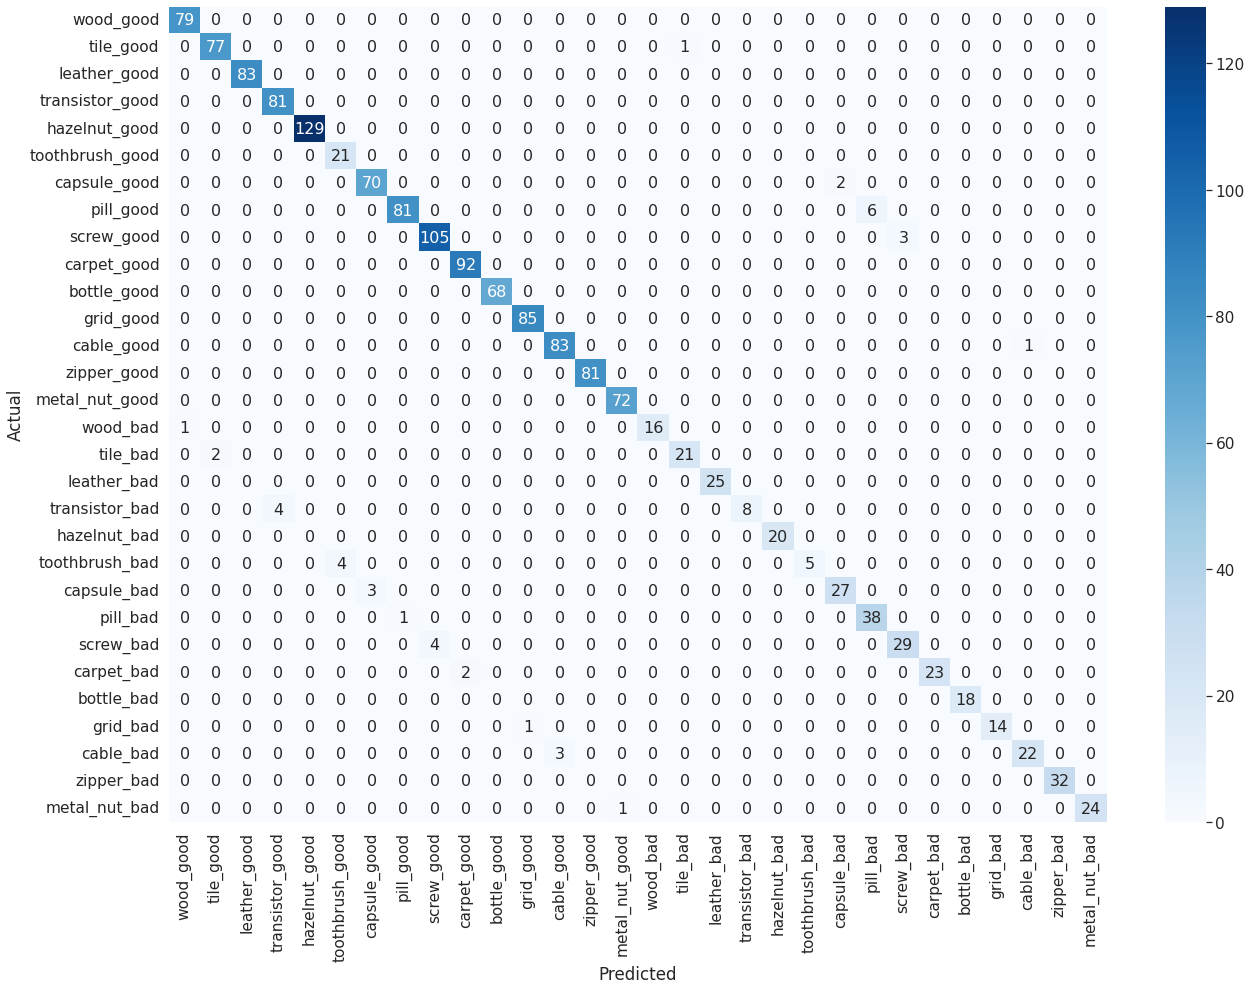

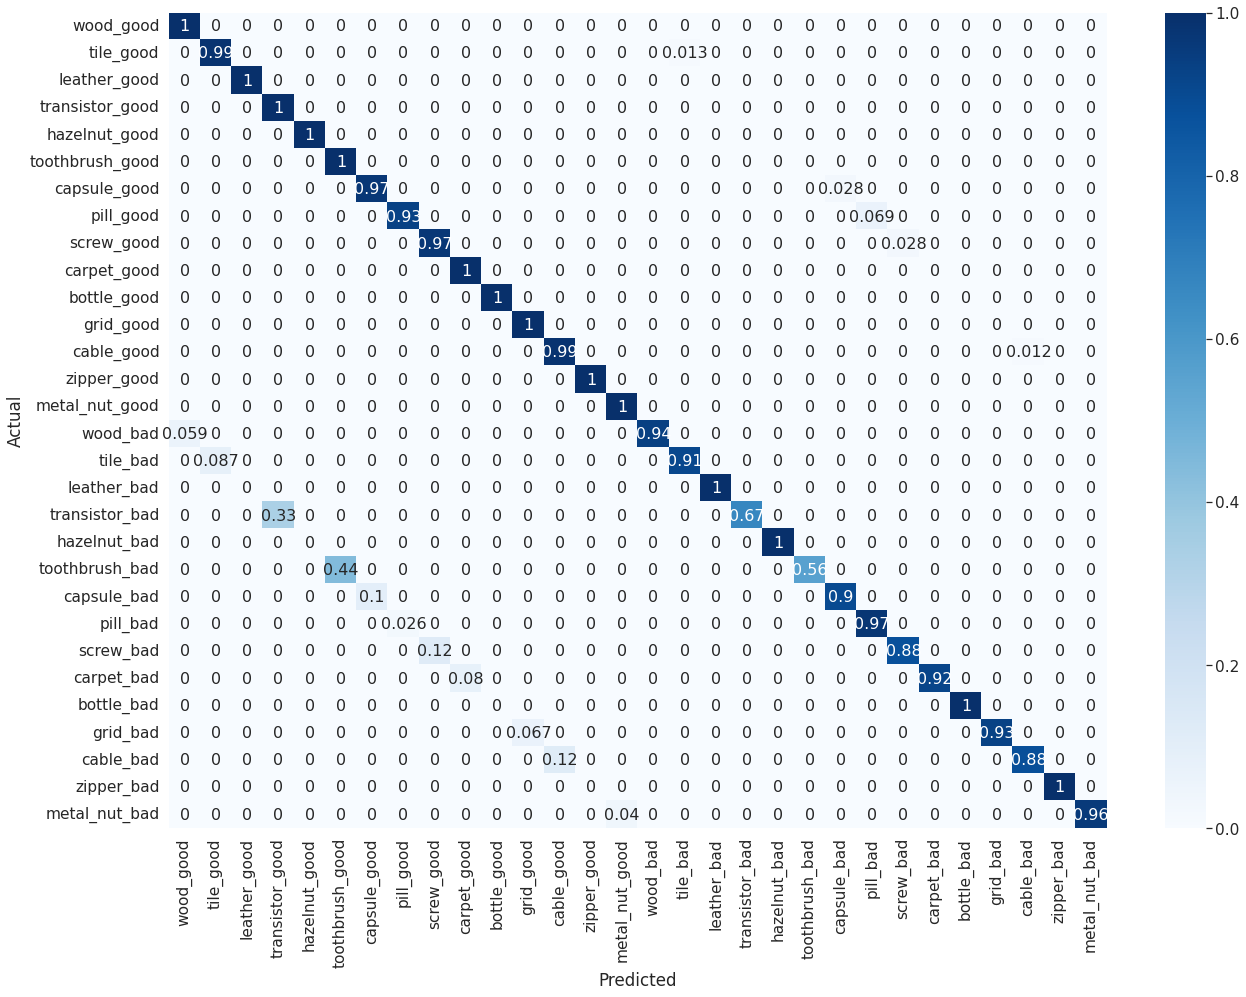

In [13]:
confususion_matrix(test_conf_matrix)

In [ ]:
from google.colab import files
files.download(Path)

### Define the Grad-Cam and Grad-Cam++

In [15]:
def grad_cam(model,img):
  model.eval()
  def normalize(x):
    return (x + 1e-10) / (torch.sqrt(torch.mean(torch.square(x))) + 1e-10)
  img=img.to(device)
  # get the most likely prediction of the model
  pred = model(img,val=False)
  arg_max = pred.argmax(dim=1)
  pred[:, int(arg_max)].backward()
  gradients = model.get_activations_gradient()
  gradients = normalize(gradients)
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
  activations = model.get_activations(img).detach()
  for i in range(activations.shape[1]):
      activations[:, i, :, :] *= pooled_gradients[i]
  heatmap = torch.mean(activations, dim=1).squeeze()
  heatmap = torch.max(heatmap,torch.Tensor([0]))
  # normalize the heatmap
  heatmap /= torch.max(heatmap) 
  heatmap =  heatmap.squeeze()
  return heatmap.detach().to('cpu').numpy(),int(arg_max)

In [16]:
def grad_cam_plus(model,img):
  model.eval()
  def normalize(x):
    return (x + 1e-10) / (torch.sqrt(torch.mean(torch.square(x))) + 1e-10)
  img=img.to(device)
  # get the most likely prediction of the model
  pred = model(img,val=False)
  arg_max = pred.argmax(dim=1)
  y_c = pred[:, int(arg_max)]
  pred[:, int(arg_max)].backward()
  gradients = model.get_activations_gradient()
  gradients = normalize(gradients)
  first = torch.exp(y_c)*gradients
  second = torch.exp(y_c)*gradients*gradients
  third = torch.exp(y_c)*gradients*gradients*gradients
  activations = model.get_activations(img).detach()
  global_sum = torch.sum(activations, dim=[0, 2, 3])
  global_sum = global_sum.reshape(global_sum.shape[0],1,1)
  alpha_num = first[0]
  alpha_denom = second[0]*2.0+third[0]*global_sum
  alphas = alpha_num/alpha_denom 
  weights = torch.max(gradients[0],torch.Tensor([0]))
  alpha_normalization_constant  = torch.sum(alphas, dim=[1, 2])
  alpha_normalization_constant = alpha_normalization_constant.reshape(alpha_normalization_constant.shape[0],1,1)
  alphas /= alpha_normalization_constant
  deep_linearization_weights = weights*alphas
  deep_linearization_weights = torch.sum(deep_linearization_weights, dim=[1, 2])
  deep_linearization_weights = deep_linearization_weights.reshape(deep_linearization_weights.shape[0],1,1)
  grad_CAM_map = torch.sum(deep_linearization_weights*activations[0],axis=0)
  heatmap = torch.max(grad_CAM_map,torch.Tensor([0]))
  # normalize the heatmap
  heatmap /= torch.max(heatmap) 
  return heatmap.detach().to('cpu').numpy(),int(arg_max)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_grad(vgg1,grad_cam,model_name='VGG16'):
  invTrans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],std = [ 1., 1., 1. ])])
  predicts_30_class,heatmaps_30_class,img_origin = [],[],[]
  defects,defects_label = [],[int(1)]*15
  for i in range(15):
    defects_index = [index for index,i in  enumerate(valid_class_label[i]) if i==1]
    defects+= [valid_class_img[i][defects_index[0]]]
  goods_class,goods_class_label = [],[int(0)]*15
  for i in range(15):
    good_index = [index for index,i in  enumerate(valid_class_label[i]) if i==0]
    goods_class+= [valid_class_img[i][good_index[0]]]

  valloader = torch.utils.data.DataLoader(
      myImageFloder(defects, defects_label, False), 
      batch_size= 1, shuffle= False
          , num_workers= 0, drop_last=False
  )
  for img,_ in valloader:
    heatmap,predict = grad_cam(vgg1,img)
    predicts_30_class+=[predict]
    heatmaps_30_class+=[heatmap]
    img = invTrans(img)
    img_origin+=[img.squeeze().permute(1,2,0)]
  predicts_30_class_correct,heatmaps_30_class_correct,img_origin_correct = [],[],[]
  valloader = torch.utils.data.DataLoader(
      myImageFloder(goods_class, goods_class_label, False), 
      batch_size= 1, shuffle= False
          , num_workers= 0, drop_last=False
  )
  for img,_ in valloader:
    heatmap,predict = grad_cam(vgg1,img)
    predicts_30_class_correct+=[predict]
    heatmaps_30_class_correct+=[heatmap]
    img = invTrans(img)
    img_origin_correct+=[img.squeeze().permute(1,2,0)]

  defects,defects_label = [],[int(1)]*15
  for i in range(15):
    defects_index = [index for index,i in  enumerate(valid_class_label[i]) if i==1]
    defects+= [valid_class_img[i][defects_index[1]]]
  goods_class,goods_class_label = [],[int(0)]*15
  for i in range(15):
    good_index = [index for index,i in  enumerate(valid_class_label[i]) if i==0]
    goods_class+= [valid_class_img[i][good_index[1]]]

  valloader = torch.utils.data.DataLoader(
      myImageFloder(defects, defects_label, False), 
      batch_size= 1, shuffle= False
          , num_workers= 0, drop_last=False
  )
  predicts_30_class_2,heatmaps_30_class_2,img_origin_2 = [],[],[]
  for img,_ in valloader:
    heatmap,predict = grad_cam(vgg1,img)
    predicts_30_class_2+=[predict]
    heatmaps_30_class_2+=[heatmap]
    img = invTrans(img)
    img_origin_2+=[img.squeeze().permute(1,2,0)]
  fig = plt.figure(figsize = (30, 12))
  cbar_ax = fig.add_axes([.91, .12, .01, .75])
  for i in range(1,16):
    ax = fig.add_subplot(6, 15, i)
    ax.imshow(img_origin[i-1])
    if(i==1): ax.set_ylabel('Defects')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(6, 15, i+15)
    g3 = sns.heatmap(heatmaps_30_class[i-1],yticklabels=False,xticklabels=False,cbar=i == 1,cmap='viridis',ax=ax,cbar_ax=None if(i!=1) else cbar_ax)
    ax.title.set_text('Predict:%s'%predicts_30_class[i-1])
    if(i==1): ax.set_ylabel(model_name)
    ax = fig.add_subplot(6, 15, i+30)
    ax.imshow(img_origin_2[i-1])
    if(i==1): ax.set_ylabel('Defects')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(6, 15, i+45)
    g3 = sns.heatmap(heatmaps_30_class_2[i-1],yticklabels=False,xticklabels=False,cbar=False,cmap='viridis',ax=ax)
    ax.title.set_text('Predict:%s'%predicts_30_class_2[i-1])
    if(i==1): ax.set_ylabel(model_name)
    ax = fig.add_subplot(6, 15, i+60)
    ax.imshow(img_origin_correct[i-1])
    if(i==1): ax.set_ylabel('Good')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(6, 15, i+75)
    g3 = sns.heatmap(heatmaps_30_class_correct[i-1],yticklabels=False,xticklabels=False,cbar=False,cmap='viridis')
    ax.title.set_text('Predict:%s'%predicts_30_class_correct[i-1])
    if(i==1): ax.set_ylabel(model_name)

###Take the gradient of last residual block's feature map on outputs
Since the last vgg block's feature map size is 7x7, then the Grad-Cam result is 14x14

In [18]:
class VGG(nn.Module):
    def __init__(self,model):
        super(VGG, self).__init__()     
        self.vgg = model
        self.features_conv = self.vgg.features_conv 
        self.Conv_0  = self.vgg.Conv2d_0[:20]
        self.maxpool  = self.vgg.Conv2d_0[20]
        self.avgpool = self.vgg.avgpool    
        self.classifier = self.vgg.classifier       
        self.gradients = None  
    def activations_hook(self, grad):
        self.gradients = grad       
    def forward(self, x,val=True):
        x = self.features_conv(x)    
        x = self.Conv_0(x) 
        if(val==False):  
          h = x.register_hook(self.activations_hook) 
        x = self.maxpool(x)  
        x = self.avgpool(x)            
        x = x.view((-1, 25088))
        x = self.classifier(x)
        return x   
    def get_activations_gradient(self):
        return self.gradients
    def get_activations(self, x):
       x = self.features_conv(x)    
       x = self.Conv_0(x) 
       return x
device = "cpu" 
vgg1 = VGG(model).to(device)

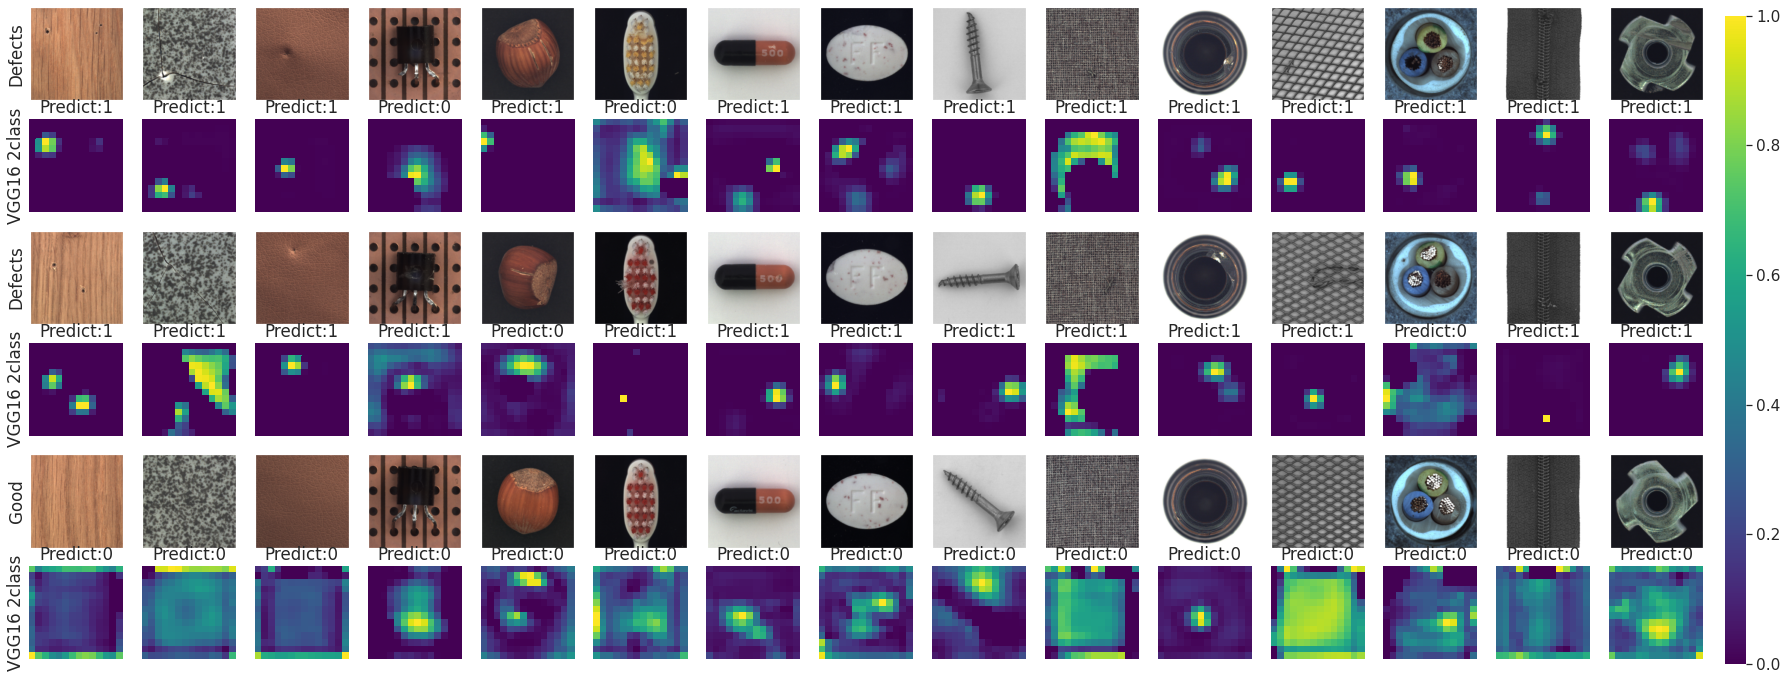

In [19]:
plot_grad(vgg1,grad_cam,model_name='VGG16 2class')

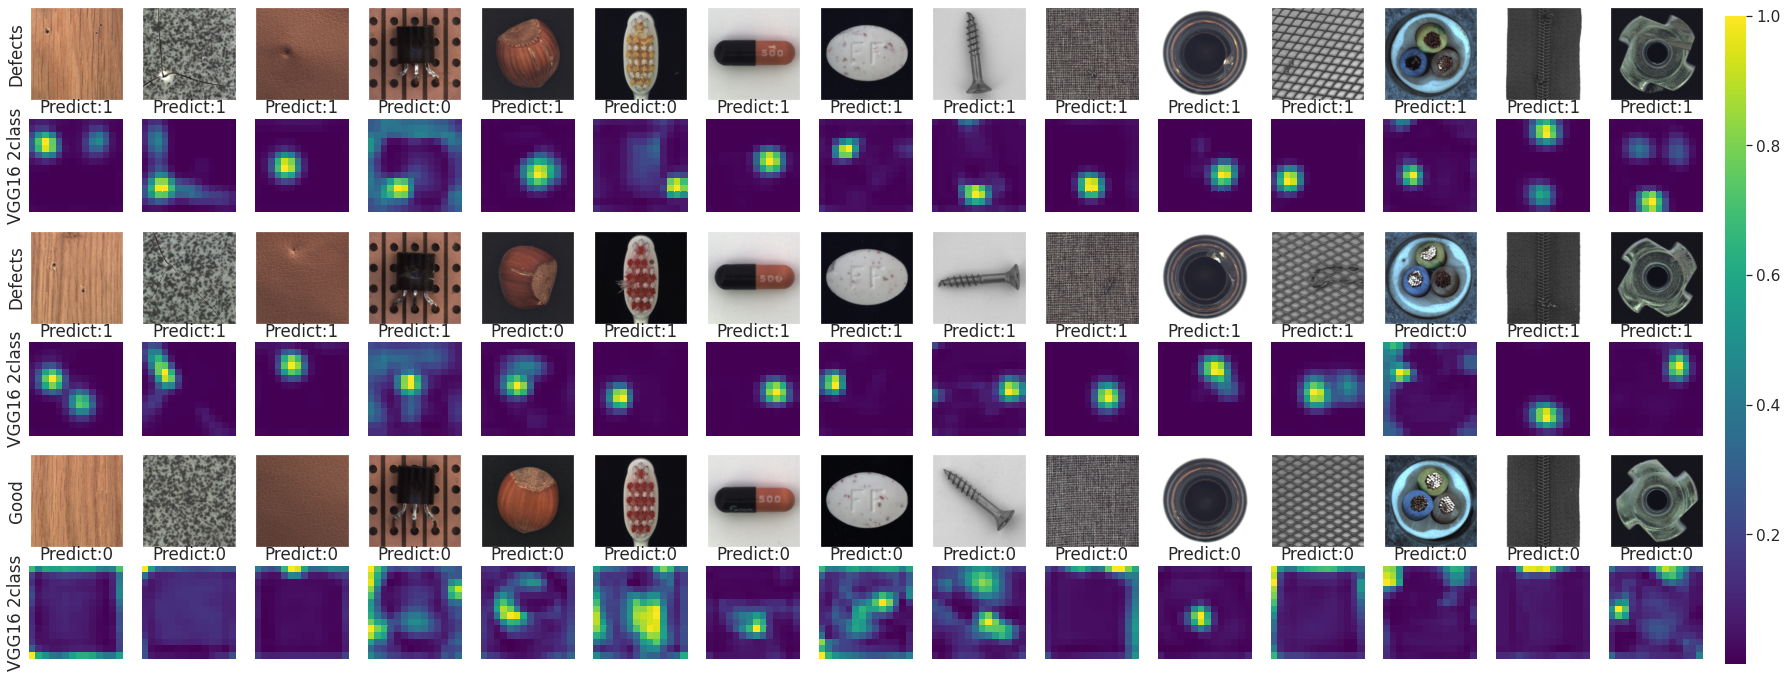

In [20]:
plot_grad(vgg1,grad_cam_plus,model_name='VGG16 2class')